In [1]:
__author__ = 'Kayli Glidic'

# Import Library

In [4]:
#import the spectroscopic module from the tshirt pipeline
from tshirt.pipeline import spec_pipeline

#import the RECTE charge trap correction functions
import Charge_Correction_Functions
from Charge_Correction_Functions import RECTE,RECTEMulti,calculate_correction_fast, charge_correction

#import the light curve modeling functions
import Transit_Eclipse_Modeling_Functions
from Transit_Eclipse_Modeling_Functions import transit_model,transit_model_RECTE,eclipse_model,eclipse_model_RECTE,barycenter_correction,optimize_batman_model,optimize_batman_model_RECTE

#import the MCMC Analysis Functions
import MCMC_Analysis_Functions
from MCMC_Analysis_Functions import log_likelihood,log_prior,log_probability,MCMC

#import basic plotting libraries/set plot settings
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

#import yaml to read in the parameter file
import yaml

#saving tables/reading in files
import os
from astropy.table import QTable
from astropy.table import Table, join
from astropy.io import fits, ascii
import pandas as pd
from copy import deepcopy

#Basic imports
import astropy.units as u
import numpy as np
import time

#modeling transit/eclipse light curves
from multiprocessing import Pool
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import batman
import corner
import emcee

#De-bugging tool
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time


Loading BokehJS ...

# Batch Processing the Spectroscopic Data on CoRoT-1 b

Here, read in the batch parameter file on CoRoT-1 b as a helpful reference. 

In [5]:
#read in yaml batch parameter file on CoRoT-1 b 
with open("corot1_batch_file.yaml", "r") as stream:
    bparamfile = yaml.safe_load(stream)

bparamfile

{'procFiles': ['/fenrirdata1/es_tso/hst/visit01/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit02/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit03/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit04/*_flt.fits'],
 'excludeList': ['ibh717giq_flt.fits',
  'ibh719gkq_flt.fits',
  'ibh720i5q_flt.fits',
  'ibh721olq_flt.fits'],
 'srcName': 'CoRoT-1',
 'srcNameShort': 'corot1',
 'nightName': ['visit1', 'visit2', 'visit3', 'visit4'],
 'dispDirection': 'x',
 'starPositions': [74],
 'refPhotCentering': None,
 'bkgSubDirections': ['Y'],
 'bkgRegionsX': [[None, None]],
 'bkgOrderX': 0,
 'bkgRegionsY': [[[9, 32], [41, 49], [92, 122]],
  [[0, 14], [25, 32], [39, 56], [100, 121]],
  [[9, 32], [39, 46], [92, 122]],
  [[9, 32], [39, 46], [92, 122]]],
 'bkgOrderY': 1,
 'apWidth': 30.0,
 'dispPixels': [0, 128],
 'numSplineKnots': 6,
 'splineSpecFitOrder': 2,
 'sigForBadPx': 300,
 'jdRef': 2457551,
 'timingMethod': None,
 'isCube': False,
 'cubePlane': 0,
 'doCentering': False,
 'FITSextension': 1,
 'HEADextens

A batch object can iterate over any spec object. In order to analyze the spectroscopic data of CoRoT-1 b, read in the batch parameter file by creating a `tshirt.pipeline.spec_pipeline.batch_spec` object to iterate over many different `tshirt.pipeline.spec_pipeline.spec` methods. 

In [6]:
bspec = spec_pipeline.batch_spec(batchFile='corot1_batch_file.yaml') #create a batch_spec object

Working on showStarChoices for batch CoRoT-1 corot1_visit1 
Working on showStarChoices for batch CoRoT-1 corot1_visit2 
Working on showStarChoices for batch CoRoT-1 corot1_visit3 
Working on showStarChoices for batch CoRoT-1 corot1_visit4 


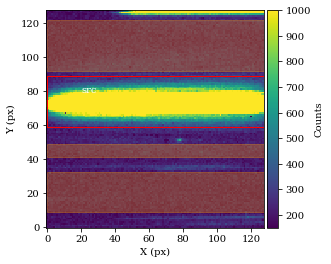

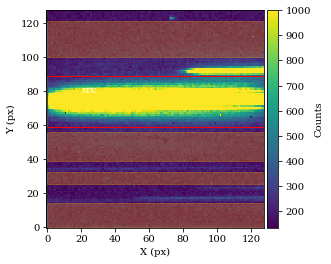

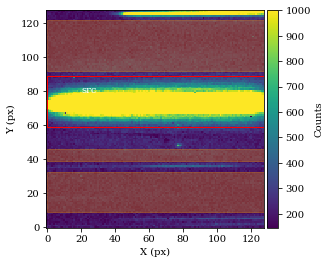

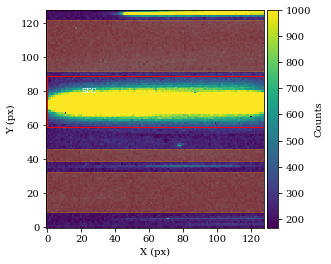

In [7]:
bspec.batch_run('showStarChoices',vmax=1000,showPlot=True) #show the star choices for spectroscopy for each visit

Proceed to extract all spectroscopic data with `do_extraction`, a tshirt.pipeline.spec_pipeline.spec method. Within the argument of the method, set `useMultiproccessing=True` to run the code faster by using more CPUs.

In [8]:
bspec.batch_run('do_extraction',useMultiprocessing=True) #extract all spectroscopy

Working on do_extraction for batch CoRoT-1 corot1_visit1 
On 0 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit2 


On 0 of 98
On 15 of 98
On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit3 
On 0 of 98

On 15 of 98On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98


/home/kglidic/Software/tshirt/tshirt/pipeline/phot_pipeline.py:2409: UserWarning: Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data
  warnings.warn("Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data")


On 90 of 98
Working on do_extraction for batch CoRoT-1 corot1_visit4 
On 0 of 98On 15 of 98

On 30 of 98
On 45 of 98
On 60 of 98
On 75 of 98
On 90 of 98


Working on plot_one_spec for batch CoRoT-1 corot1_visit1 


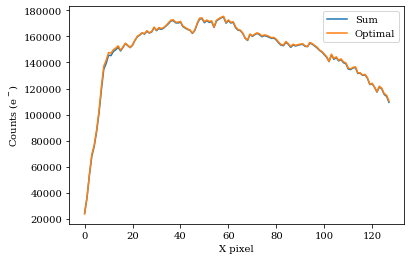

Working on plot_one_spec for batch CoRoT-1 corot1_visit2 


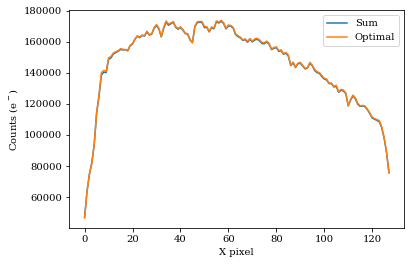

Working on plot_one_spec for batch CoRoT-1 corot1_visit3 


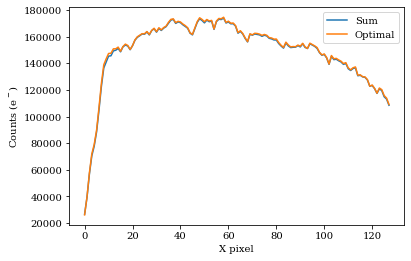

Working on plot_one_spec for batch CoRoT-1 corot1_visit4 


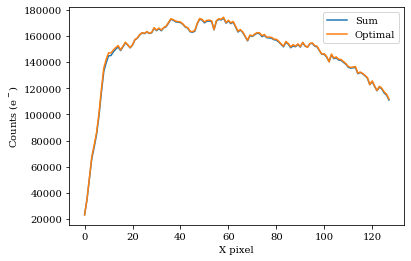

In [9]:
bspec.batch_run('plot_one_spec') #plot the spectrum of the source for each visit

A dynamic spectrum essentially displays a plot depicting the change in the spectrum over time. On the y-axis, each image corresponds to a time and on the x-axis, dispersion. The top plots display the average spectrums. To automatically align all spectra, set `align = True`. This alignment step will help define a range for the detector pixel indices, the indices over which to create the wavelength bins. 

Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit1 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit2 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit3 
Working on plot_dynamic_spec for batch CoRoT-1 corot1_visit4 


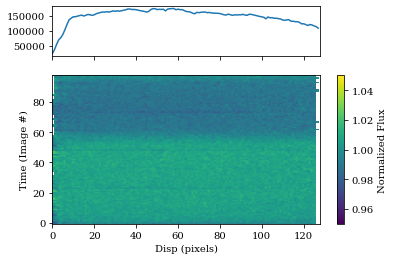

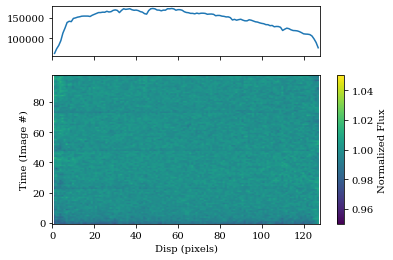

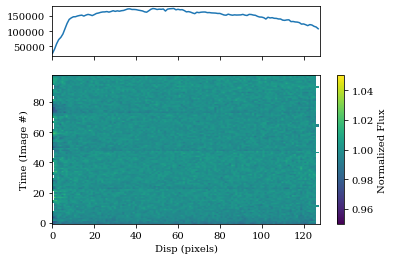

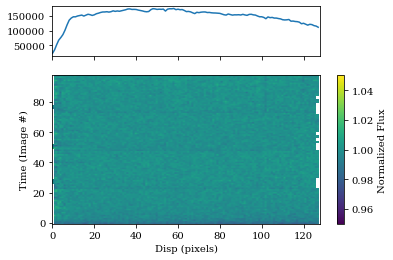

In [10]:
bspec.batch_run('plot_dynamic_spec', showPlot=True,align=True) #plot the dynamic spectrum for each visit

In order to visualize the new alignment with the `plot_wavebin_series` method, one must first generate a new time series from the aligned dynamic spectrum (the step above) using the `make_wavebin_series` method. In the `make_wavebin_series` method arguments, one can set `dispIndicies` to a range that defines the detector pixel indices over which to create the wavelength bins, set `recalculate=True` to recalculate the dynamic spectrum, and set `align=True` to align all the spectra (argument passed to the `plot_dynamic_spec` module. 

In [11]:
#Bin the wavelengths together and generate a time series from the aligned dynamic spectrum (`make_wavebin_series`)
#Plot a normalized lightcurve for wavelength-binned data one wavelength at a time with an offset between the lightcurves (`plot_wavebin_series`)

bspec.batch_run('make_wavebin_series',align=True,dispIndices=[10,118],recalculate=True,nbins=10) #Set dispersion indices based on alignment step above in `plot_dynamic_spec`.
bspec.batch_run('plot_wavebin_series', nbins=10, interactive=False,savePlot=True)

Working on make_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on make_wavebin_series for batch CoRoT-1 corot1_visit4 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit1 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit2 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit3 
Working on plot_wavebin_series for batch CoRoT-1 corot1_visit4 


In [12]:
#Return a spectrometry object for each visit so other methods and attributes can be explored
spec_v1 = bspec.return_spec_obj(ind=0)
spec_v2 = bspec.return_spec_obj(ind=1)
spec_v3 = bspec.return_spec_obj(ind=2)
spec_v4 = bspec.return_spec_obj(ind=3)

In [13]:
#Read in previously saved data for each CoRoT-1 b visit
corot1_visit1_results = pd.read_csv('CSV_Visit_Files/corot1_visit1_results.csv')
corot1_visit2_results = pd.read_csv('CSV_Visit_Files/corot1_visit2_results.csv')
corot1_visit3_results = pd.read_csv('CSV_Visit_Files/corot1_visit3_results.csv')
corot1_visit4_results = pd.read_csv('CSV_Visit_Files/corot1_visit4_results.csv')

#Read in previously saved median images for each CoRoT-1 b visit
median_image_v1 = fits.getdata('Median_Images/corot1_visit1_median_image.fits')
median_image_v2 = fits.getdata('Median_Images/corot1_visit2_median_image.fits')
median_image_v3 = fits.getdata('Median_Images/corot1_visit3_median_image.fits')
median_image_v4 = fits.getdata('Median_Images/corot1_visit4_median_image.fits')

# Modeling the Eclipses of CoRoT-1 b

The following Markov chain Monte Carlo (MCMC) Analysis and Modeling of the CoRoT-1 b secondary eclipse visits can be followed within the `Transit_Eclipse_Modeling_Functions.py` and `MCMC_Analysis_Functions.py` scripts. 

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [138.62562897 146.32434405 128.95190971 380.93580938 360.32325494
 428.61437663 156.97901502]


Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/corner/corner.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


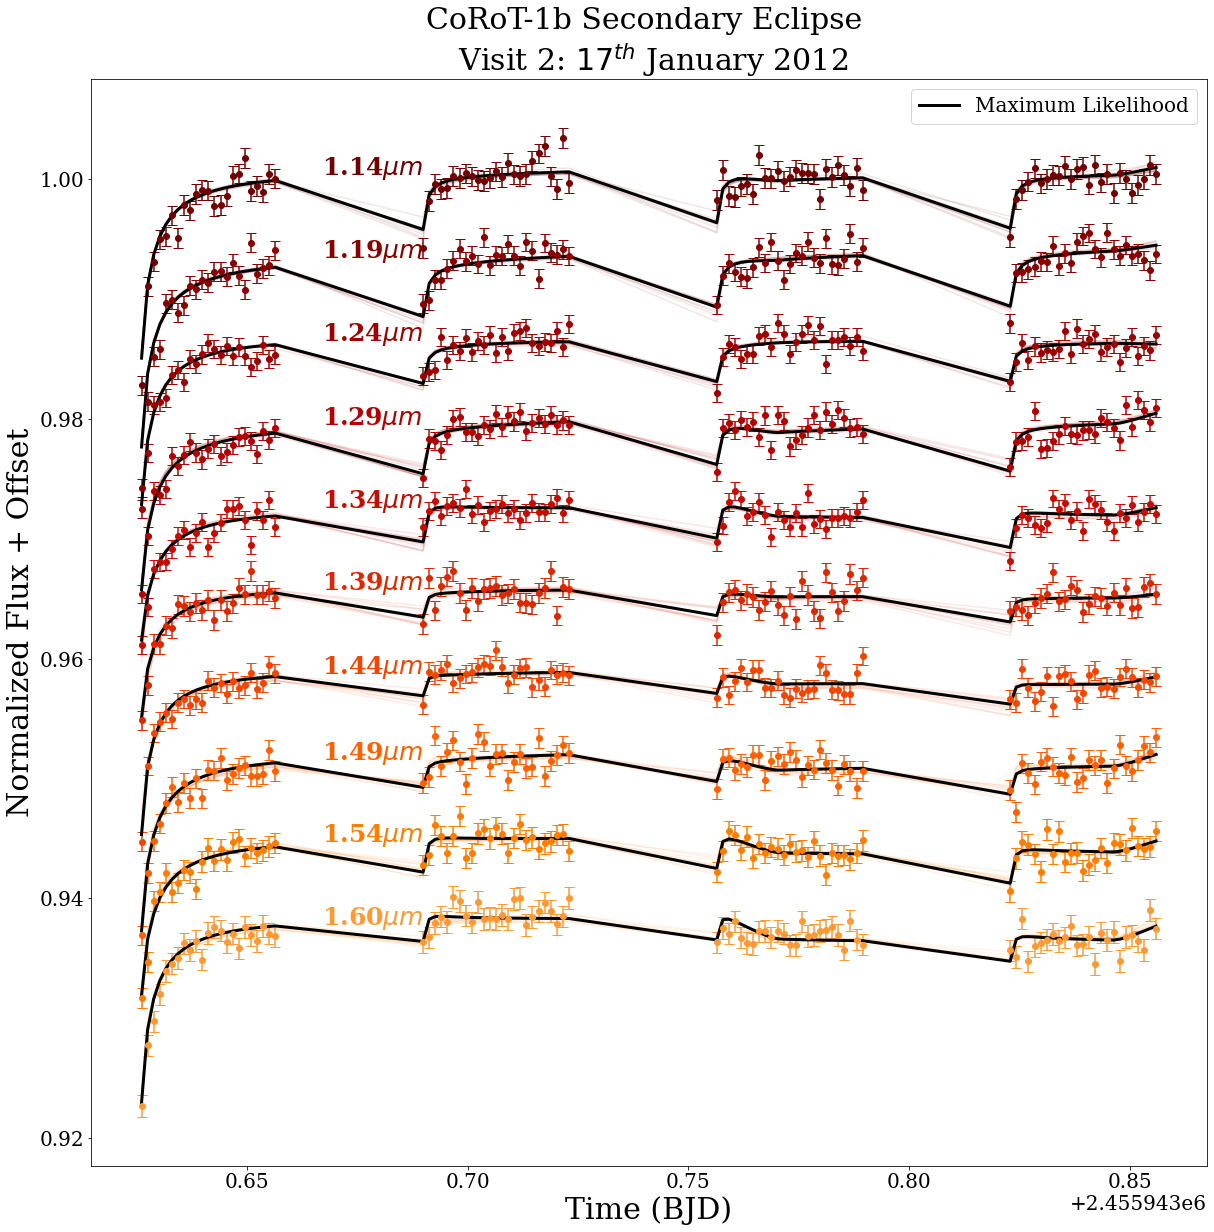

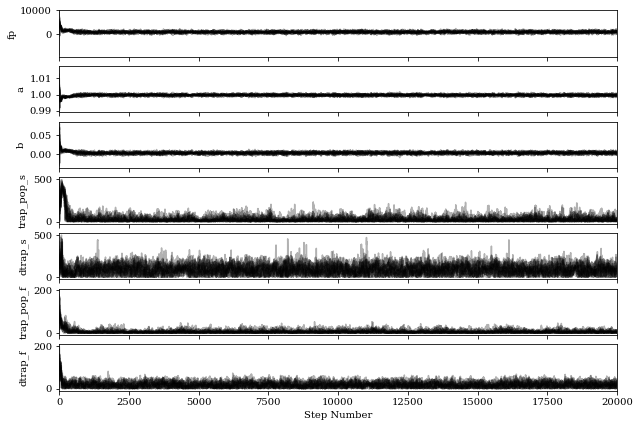

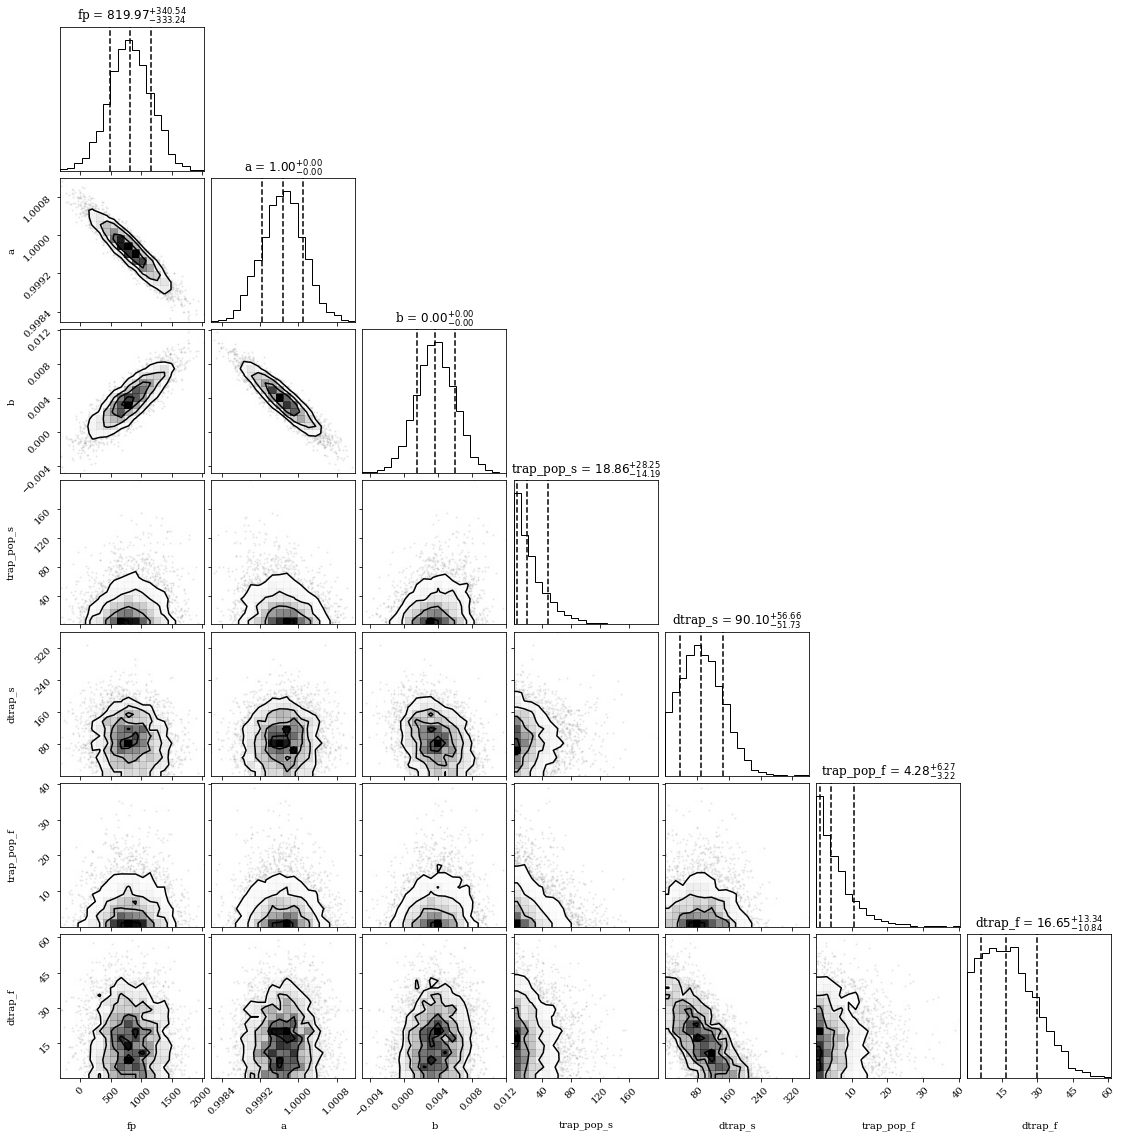

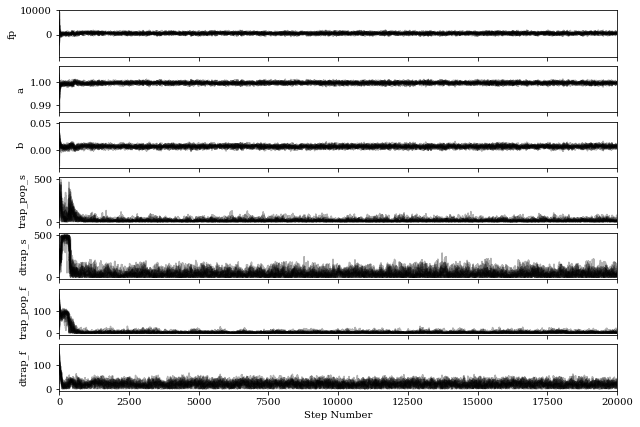

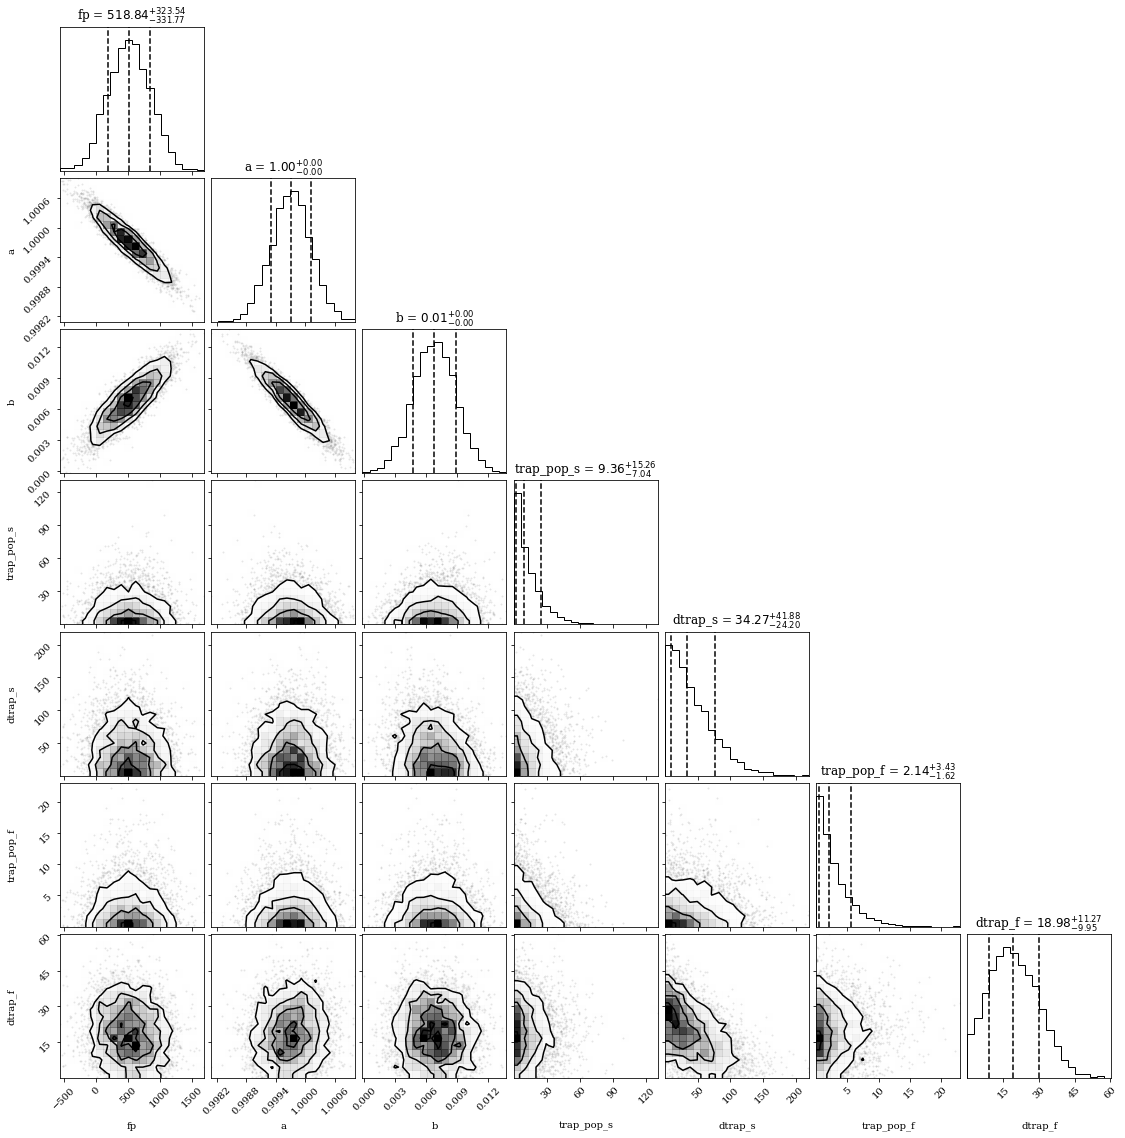

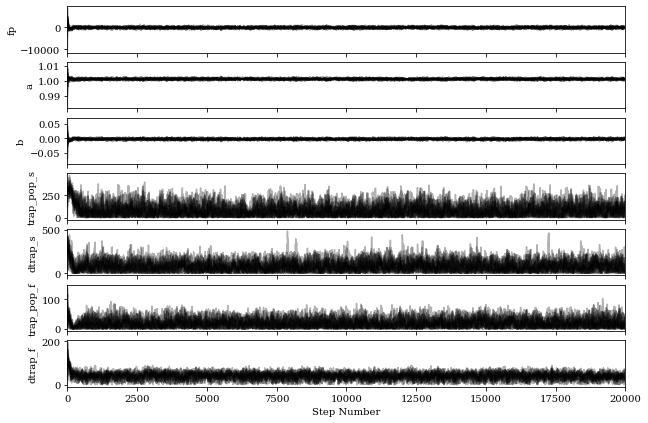

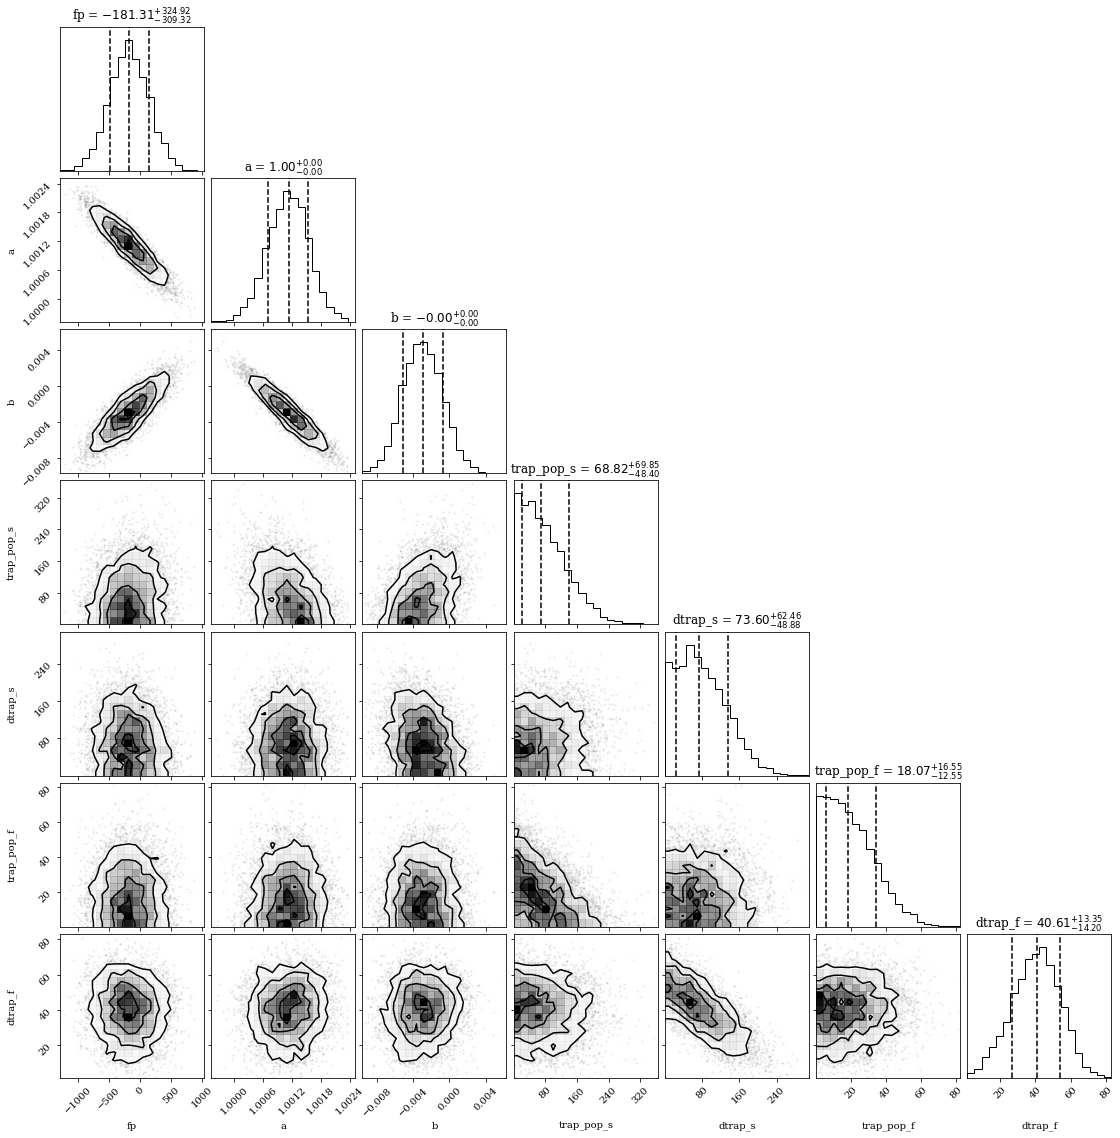

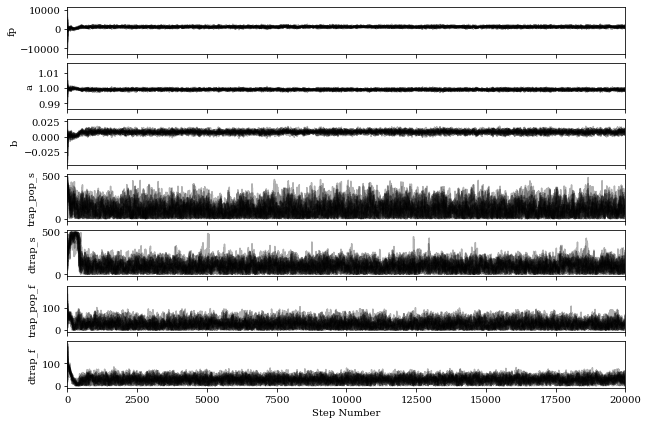

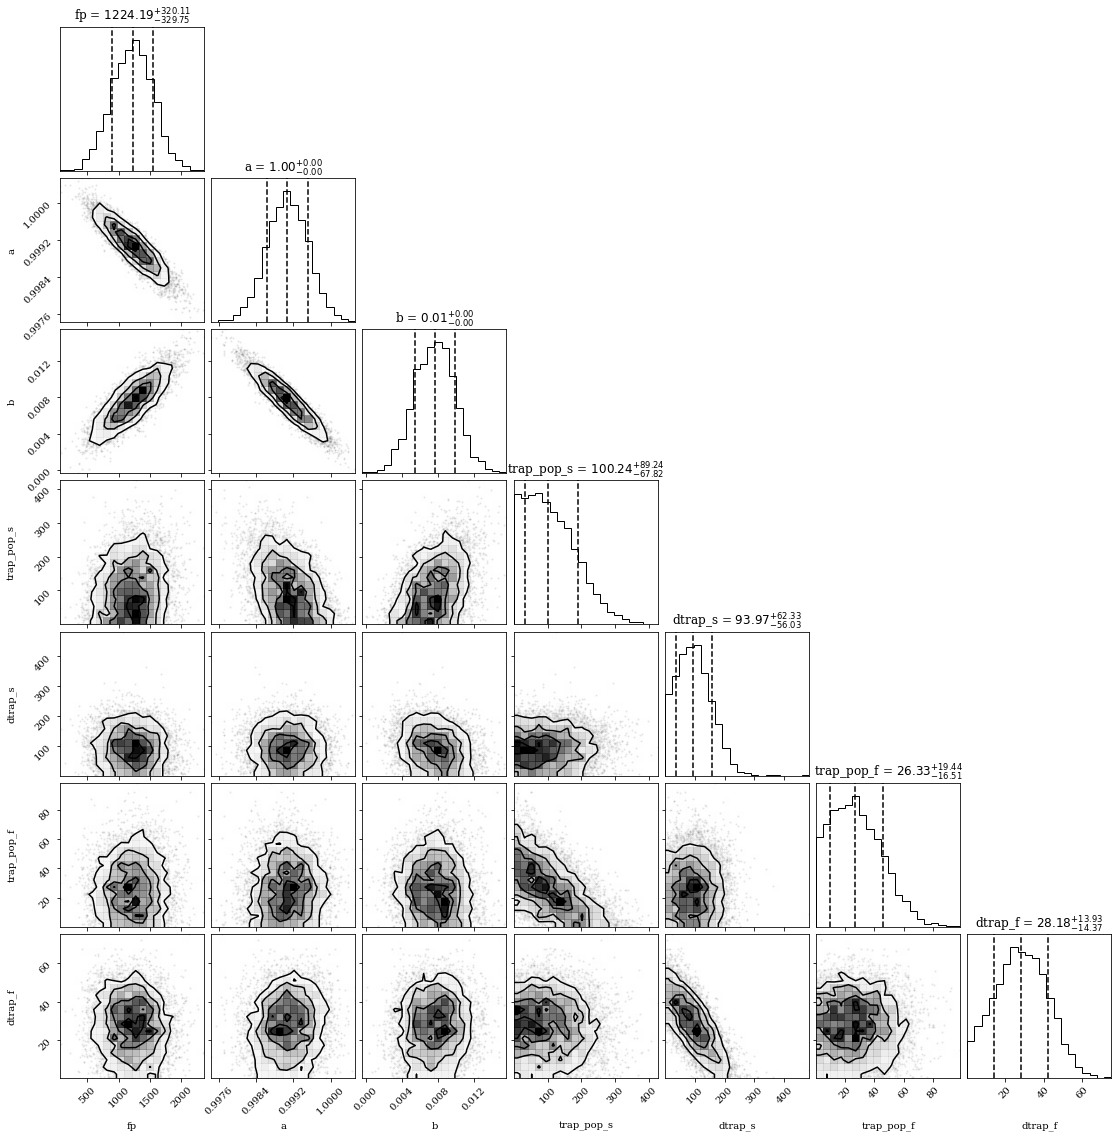

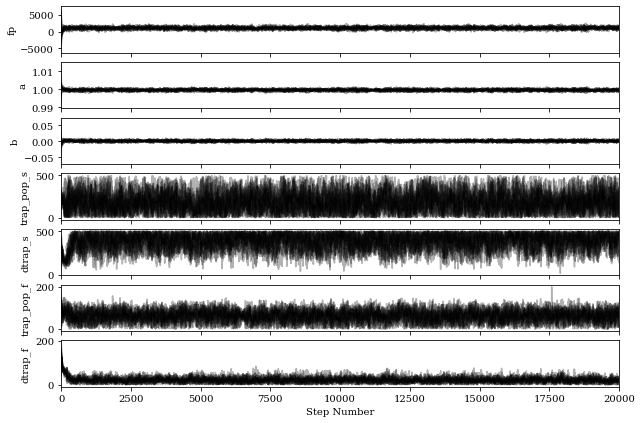

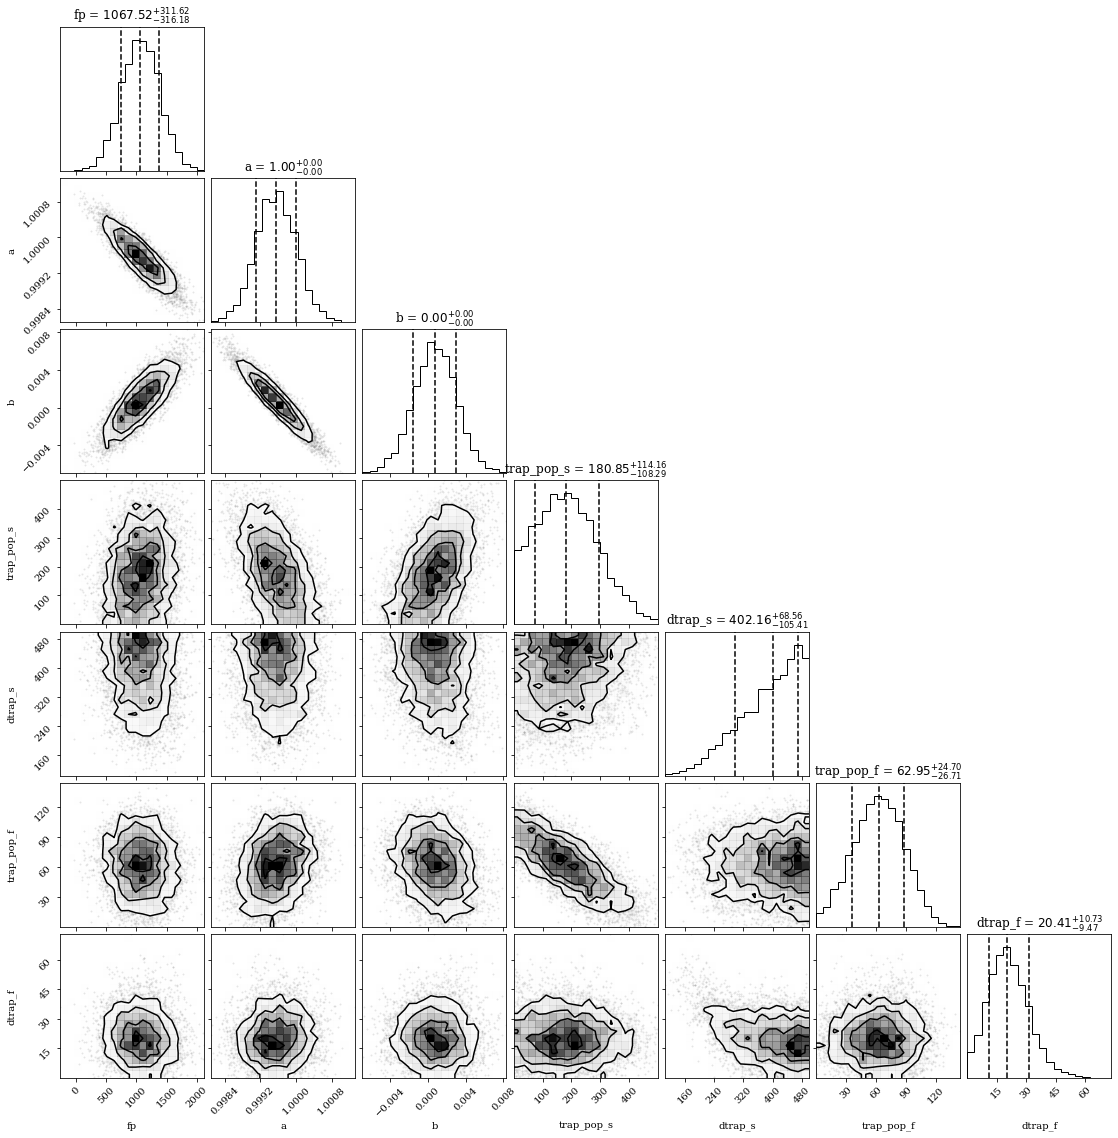

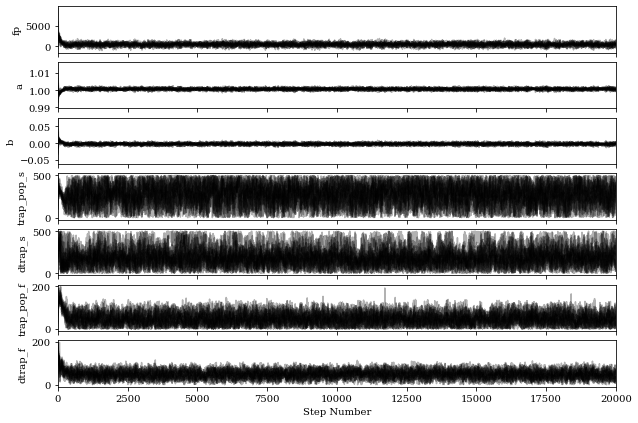

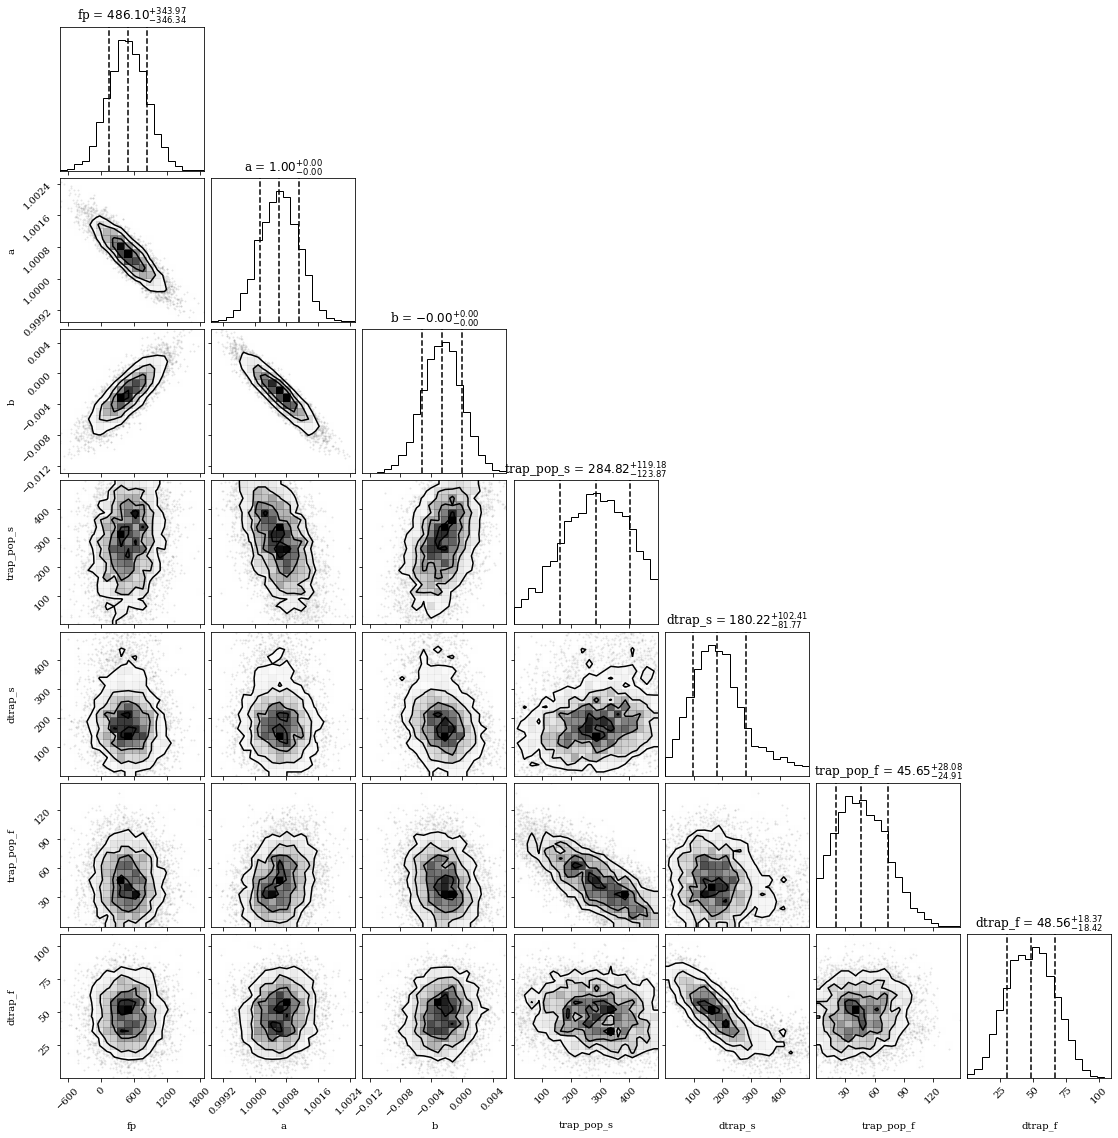

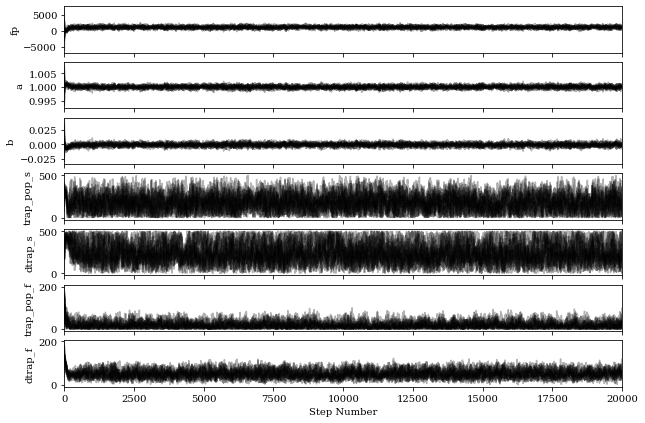

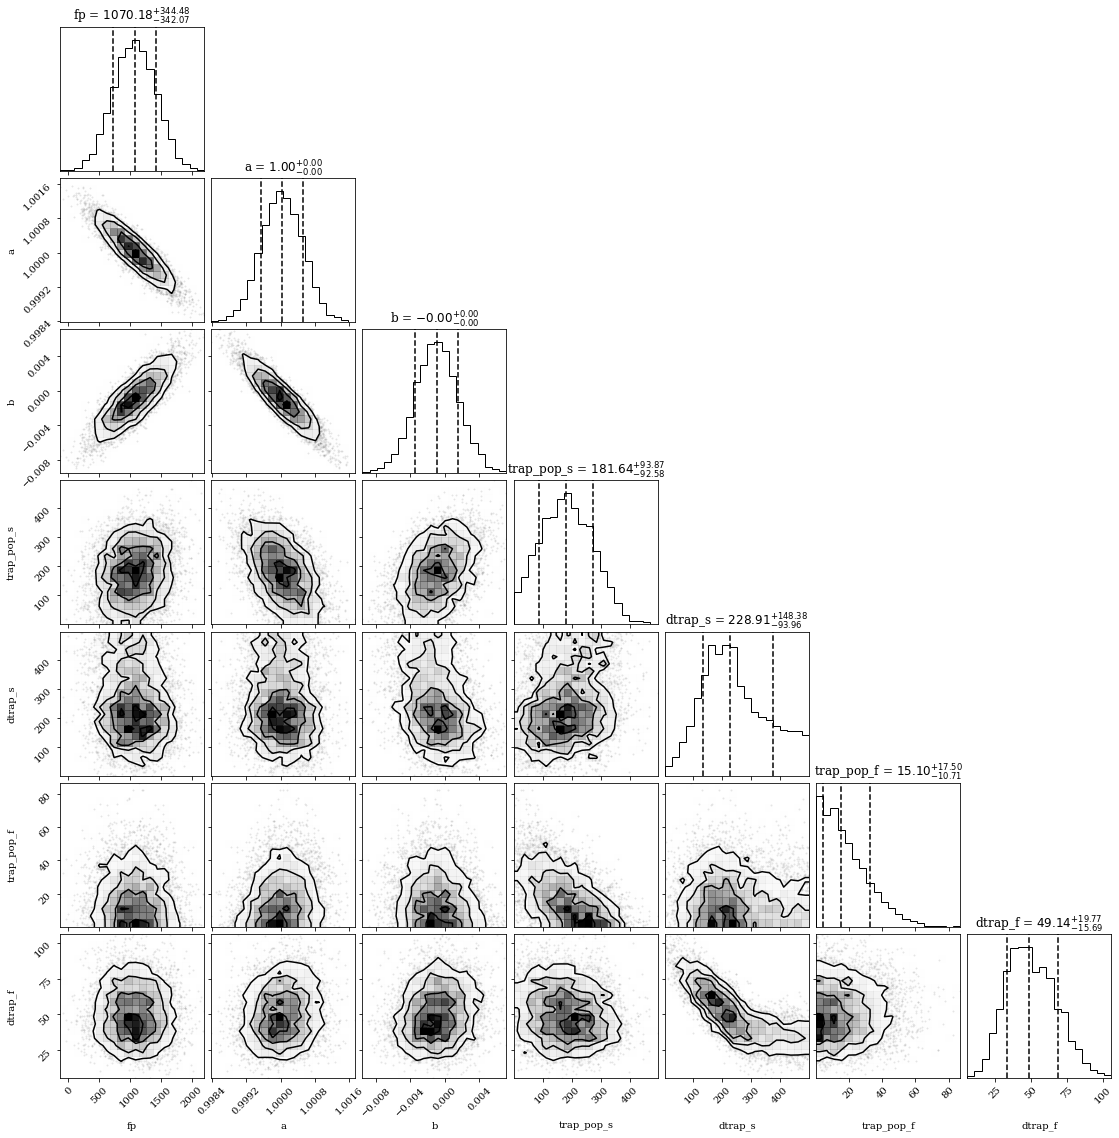

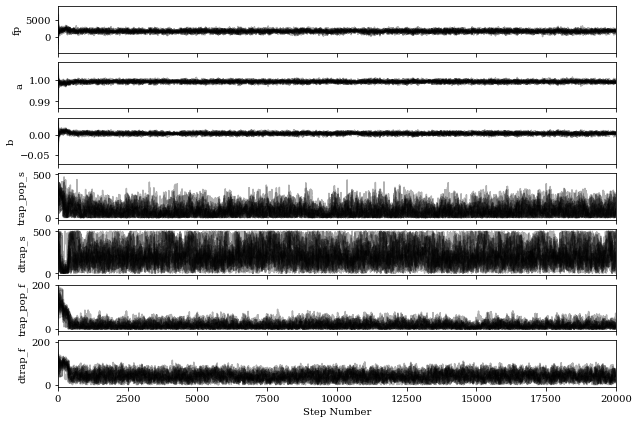

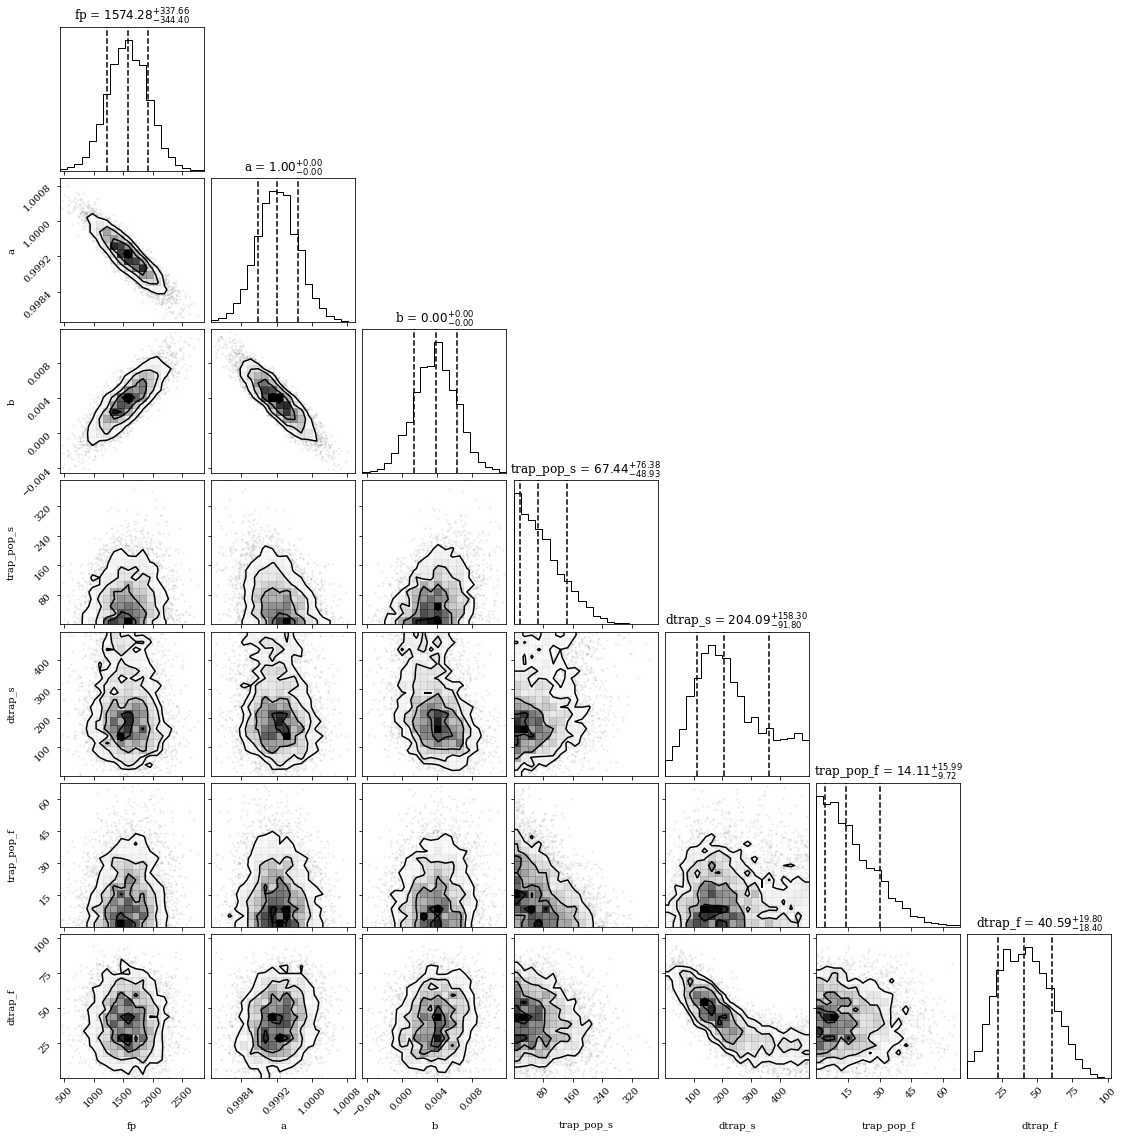

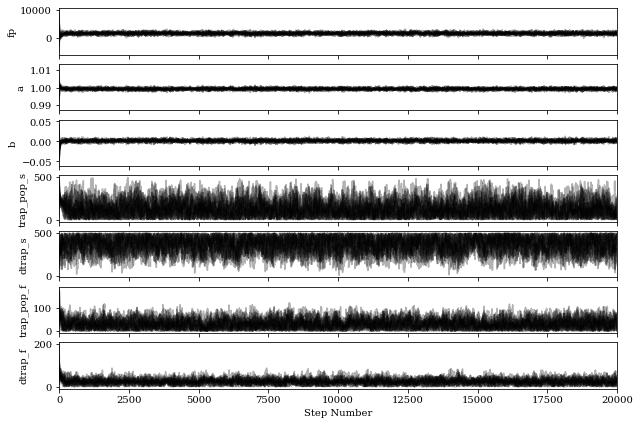

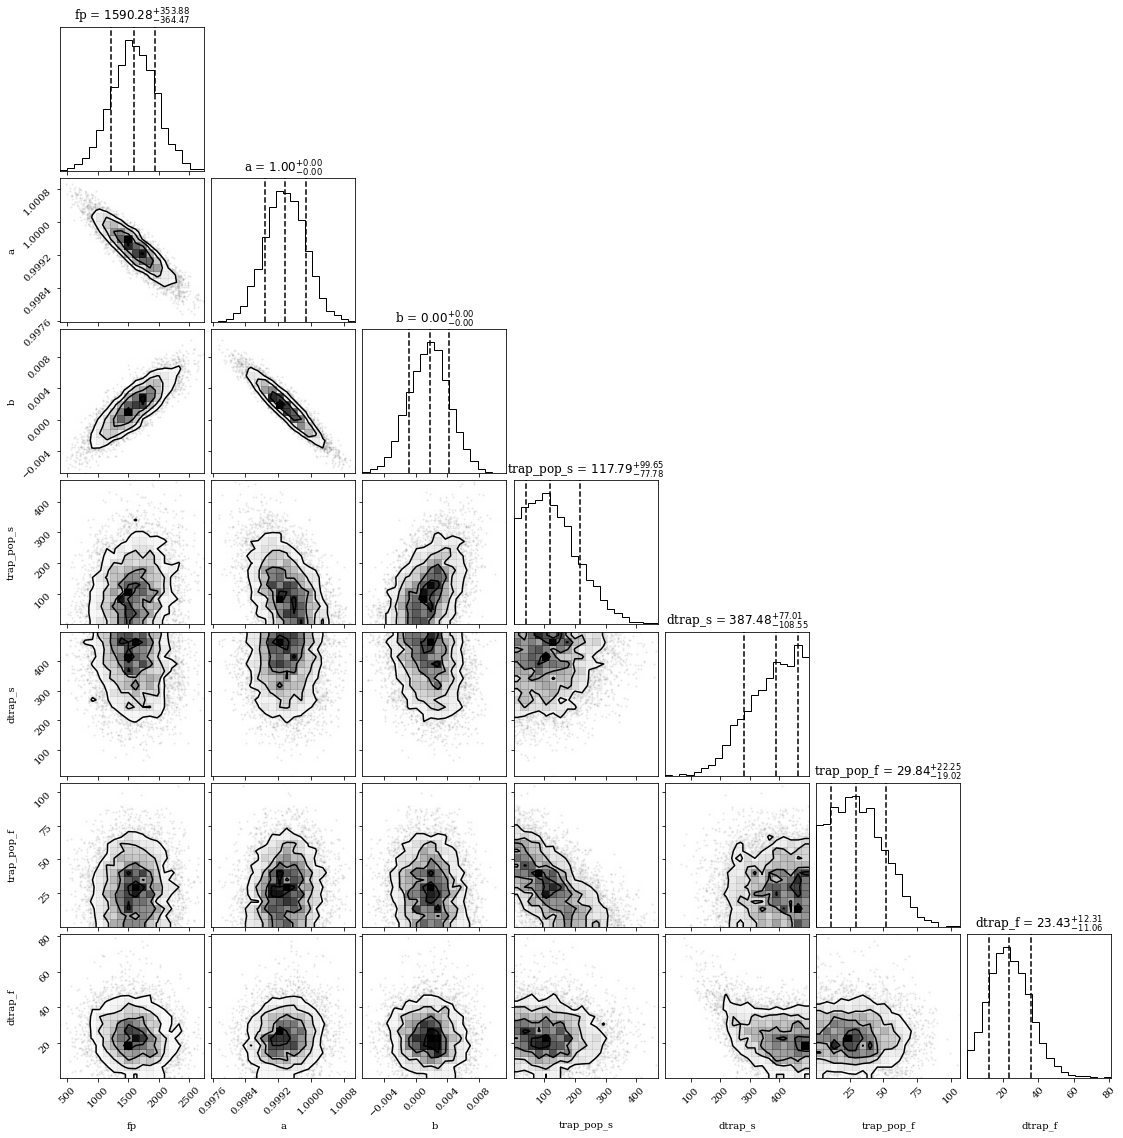

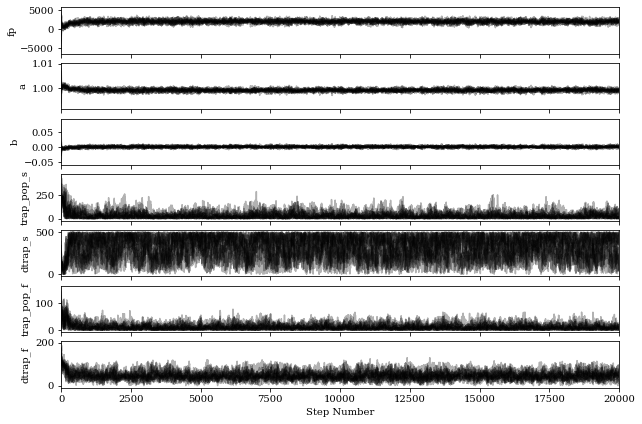

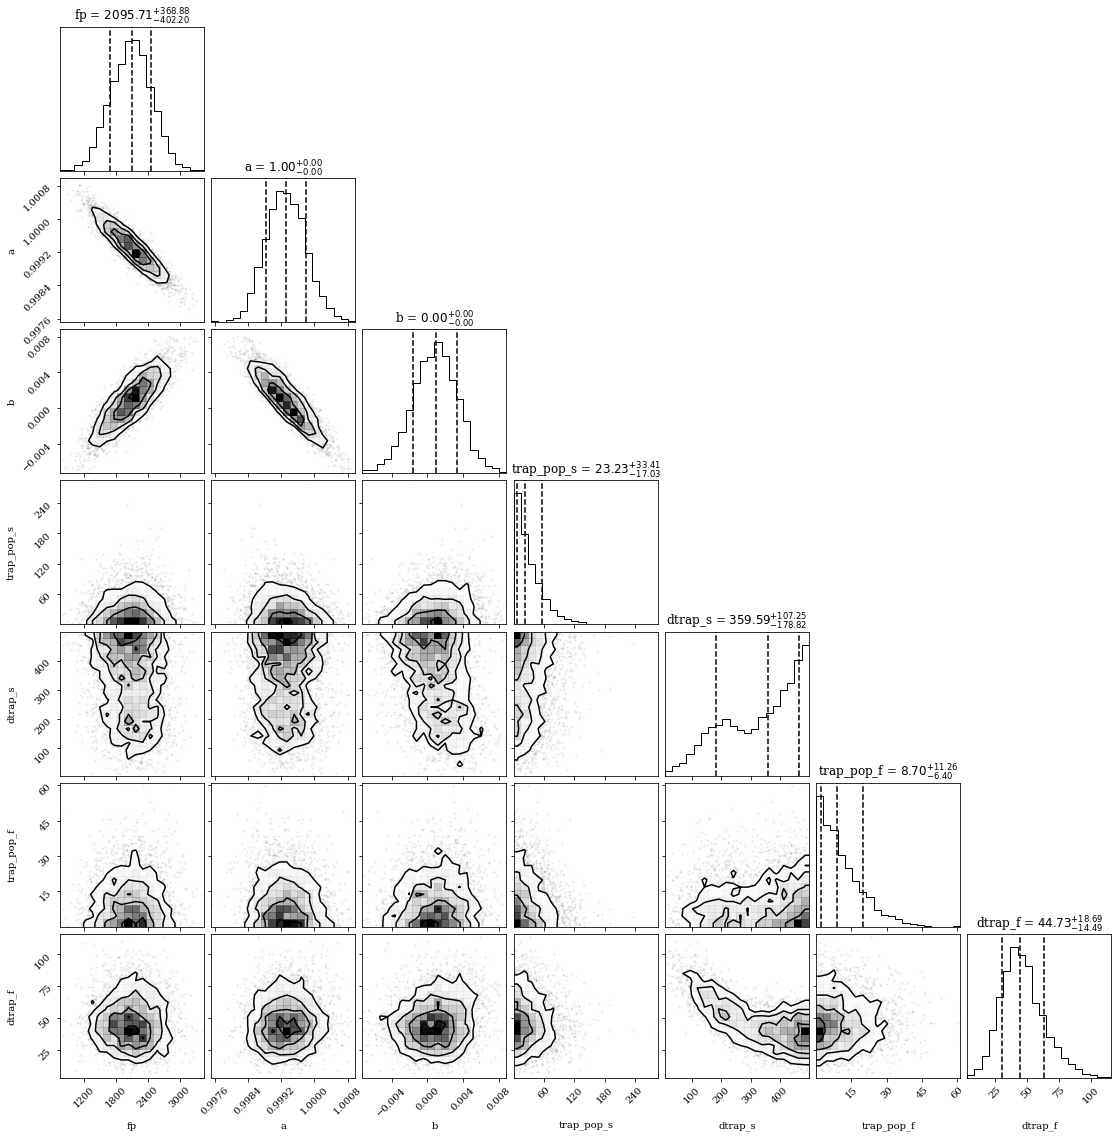

In [14]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit2_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v2 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 2 - if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_2 = MCMC(spec_v2,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=True,LCPlot=True)

In [15]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit3_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v3 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 3 - if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_3 = MCMC(spec_v3,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=False,LCPlot=False)

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


In [16]:
#Define some global parameters required for the eclipse modeling function within the `Transit_Eclipse_Modeling_Functions` script.
exptime = corot1_visit4_results['Exp Time'][0] #Define the exposure time; Here called from a previously saved table.
Transit_Eclipse_Modeling_Functions.exptime = exptime #Define the global parameter exptime (exposure time) and tell the script specifically 
Transit_Eclipse_Modeling_Functions.im = median_image_v4 #Define the global parameter im (median image) and tell the script specifically

#MCMC Analysis on CoRoT-1 b Visit 4 -  if desired: show the light curve plot (`LCPlot=True`) and the distribution plots (`showPlot=True`)
MCMC_4 = MCMC(spec_v4,eclipse_model_RECTE,20000,nbins=10,recalculate=False,showPlot=False,LCPlot=False)

Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds
Maximum Likelihood Estimation Took 0.0 Seconds


# Secondary Eclipse Plots and Models

In [17]:
#Wavelength Calibrations

#Obtain tables of wavelength bins for each visit, with theoretical noise and measured standard deviation across time.
table_noise_v1=spec_v1.print_noise_wavebin(nbins=10)
table_noise_v2=spec_v2.print_noise_wavebin(nbins=10)
table_noise_v3=spec_v3.print_noise_wavebin(nbins=10)
table_noise_v4=spec_v4.print_noise_wavebin(nbins=10)

#Wavelength calibration to turn the dispersion pixels into wavelengths. 
#CoRoT-1 b used wavecalMethod='wfc3Dispersion' for the HST WFC3 grism
wavelength_list_v1 = spec_v1.wavecal(table_noise_v1['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v2 = spec_v2.wavecal(table_noise_v2['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v3 = spec_v3.wavecal(table_noise_v3['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
wavelength_list_v4 = spec_v4.wavecal(table_noise_v4['Disp Mid'],waveCalMethod = 'wfc3Dispersion')

In [18]:
#Reading in model data and MCMC Analysis results from above

#Visit 2 - 16,50,84 quantiles
q50_values_2=[item[0] for item in MCMC_2[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 2
lower_limit_2=[item[0] for item in MCMC_2[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 2
upper_limit_2 = [item[0] for item in MCMC_2[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 2

#Visit 3 - 16,50,84 quantiles
q50_values_3=[item[0] for item in MCMC_3[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 3
lower_limit_3=[item[0] for item in MCMC_3[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 3
upper_limit_3 = [item[0] for item in MCMC_3[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 3

#Visit 4 - 16,50,84 quantiles
q50_values_4=[item[0] for item in MCMC_4[0]] #the mean value of the flux-to-planet-ratio `item[0]` for each wavelength in visit 4
lower_limit_4=[item[0] for item in MCMC_4[1]] #the lower limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 4
upper_limit_4 = [item[0] for item in MCMC_4[2]] #the upper limit of the error bar for the flux-to-planet-ratio `item[0]` for each wavelength in visit 4

#Spitzer data Deming et al. 2011
spitzer_wavelengths=[3.6,4.5] #in microns
spitzer_eclipse_depths=[(0.415/100)*1e6, (0.482/100)*1e6] #convert percent into decimal into ppm
spitzer_eclipse_depths_errors=[(0.042/100)*1e6, (0.042/100)*1e6] #convert percent into decimal into ppm

#Average all three eclipse visits together
average_lower_limit = [(g+h+k) / 3 for g,h,k in zip(lower_limit_2,lower_limit_3,lower_limit_4)] #average the lower limit of the error bars
average_upper_limit = [(g+h+k) / 3 for g,h,k in zip(upper_limit_2,upper_limit_3,upper_limit_4)] #average the upper limits of the error bars
average_q50_values = [(g+h+k) / 3 for g,h,k in zip(q50_values_2,q50_values_3,q50_values_4)] #average the flux-to-planet ratio of all visits for all wavelengths
average_wavelengths = [(g+h+k) / 3 for g,h,k in zip(wavelength_list_v2,wavelength_list_v3,wavelength_list_v4)] #average the wavelengths 

#Read in Mike Line Theroretical Model Data
redist_266=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_2.66_logZ_+0.0_CtoO_0.55_spec.csv',sep=" ")
redist_1=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_1.0_logZ_+0.0_CtoO_0.55_spec.csv',sep=" ")
redist_2=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_2.0_logZ_+0.0_CtoO_0.55_spec.csv',sep=" ")

# Model TP profile
TP_redist_266=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_2.66_logZ_+0.0_CtoO_0.55_ATM.csv',sep=" ")
TP_redist_2=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_2.0_logZ_+0.0_CtoO_0.55_ATM.csv',sep=" ")
TP_redist_1=pd.read_csv('Mike_Line_Theoretical_Data/COROT-1b_redist_1.0_logZ_+0.0_CtoO_0.55_ATM.csv',sep=" ")


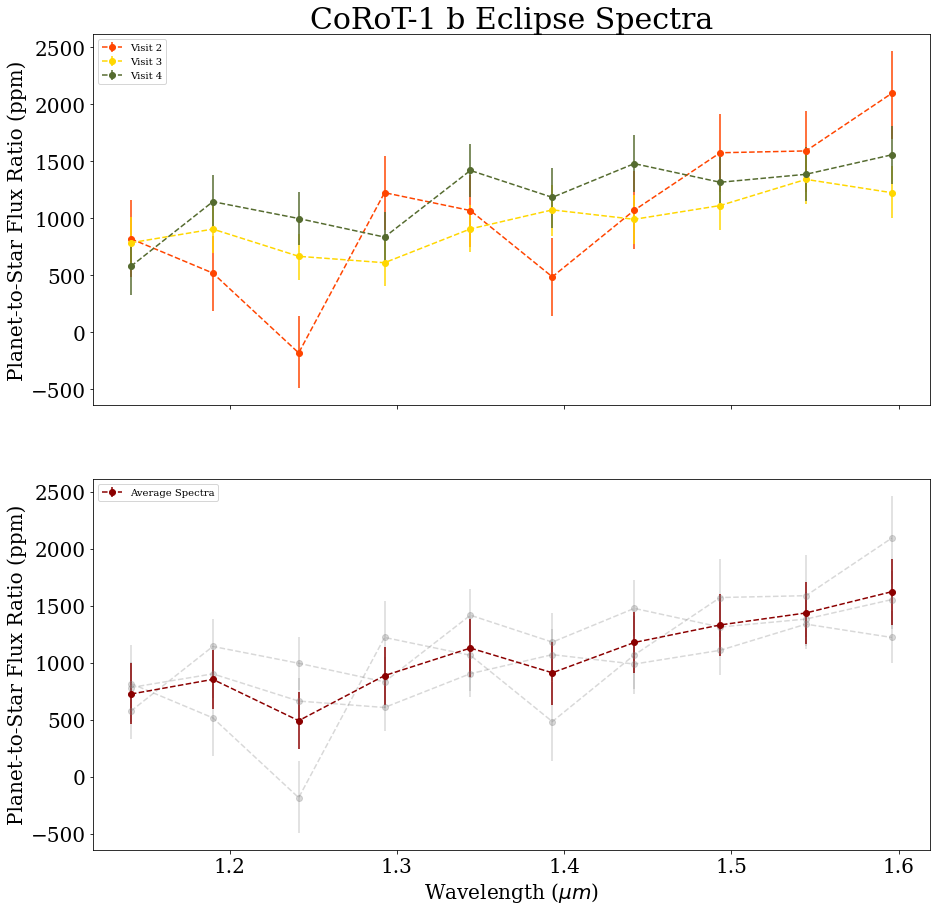

In [19]:
#Plot The Eclipse Spectra

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15), sharex=True) #set up the figure space

#Plot each visit's secondary eclipse spectra overlaid. 
ax1.errorbar(wavelength_list_v2,q50_values_2,yerr=[lower_limit_2, upper_limit_2],label='Visit 2',fmt='--o', color='orangered')
ax1.errorbar(wavelength_list_v3,q50_values_3,yerr=[lower_limit_3, upper_limit_3],label='Visit 3',fmt='--o', color='gold')
ax1.errorbar(wavelength_list_v4,q50_values_4,yerr=[lower_limit_4, upper_limit_4],label='Visit 4',fmt='--o', color='darkolivegreen')
ax1.legend(loc="upper left")

#Plot the average secondary eclipse spectra
ax2.errorbar(wavelength_list_v2,q50_values_2,yerr=[lower_limit_2, upper_limit_2],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference 
ax2.errorbar(wavelength_list_v3,q50_values_3,yerr=[lower_limit_3, upper_limit_3],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference
ax2.errorbar(wavelength_list_v4,q50_values_4,yerr=[lower_limit_4, upper_limit_4],fmt='--o', color='grey', alpha=0.3) #original specta faded for reference
ax2.errorbar(average_wavelengths,average_q50_values,yerr=[average_lower_limit,average_upper_limit],label='Average Spectra',fmt='--o', color="darkred")
ax2.legend(loc="upper left")

#Plot labels
ax1.set_title("CoRoT-1 b Eclipse Spectra", fontsize = 30)
ax1.set_ylabel("Planet-to-Star Flux Ratio (ppm)", fontsize=20)
ax2.set_ylabel("Planet-to-Star Flux Ratio (ppm)", fontsize=20)
ax2.set_xlabel("Wavelength ($\mu m$)", fontsize=20)
ax1.tick_params(axis = 'both',labelsize = 20)
ax2.tick_params(axis = 'both',labelsize = 20)



#fig.savefig('saved_figures/CoRoT-1b_MCMC_Eclipse_Spectra.jpeg', bbox_inches='tight')


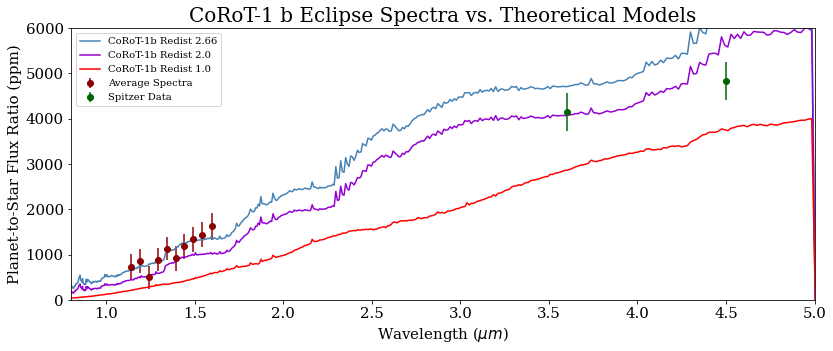

In [20]:
# Plot The Eclipse Spectra against CHIMERA models
fig, ax2 = plt.subplots(figsize=(960/72,360/72)) #set up the figure space

ax2.errorbar(average_wavelengths,average_q50_values,yerr=[average_lower_limit,average_upper_limit],label='Average Spectra',fmt='o', color="darkred") #calculated average secondary eclipse spectra
ax2.errorbar(spitzer_wavelengths,spitzer_eclipse_depths,yerr=spitzer_eclipse_depths_errors,label='Spitzer Data',fmt='o', color='darkgreen') #Spitzer data 
ax2.plot(redist_266['#Wavelength[um]'],redist_266['Fp/Fstar[ppm]'],label="CoRoT-1b Redist 2.66",color='steelblue') #No Heat Redistribution Secondary Eclipse Model for CoRoT-1 b
ax2.plot(redist_2['#Wavelength[um]'],redist_2['Fp/Fstar[ppm]'],label='CoRoT-1b Redist 2.0',color='darkviolet') #Dayside Only Heat Redistribution Secondary Eclipse Model for CoRoT-1 b
ax2.plot(redist_1['#Wavelength[um]'],redist_1['Fp/Fstar[ppm]'],label='CoRoT-1b Redist 1.0',color='red') #Full Heat Redistribution Secondary Eclipse Model for CoRoT-1 b
ax2.legend()

#Plot labels/limits
ax2.set_xlim(0.8,5)
ax2.set_ylim(0,6000)

ax2.set_title("CoRoT-1 b Eclipse Spectra vs. Theoretical Models", fontsize = 20)
ax2.set_ylabel("Planet-to-Star Flux Ratio (ppm)", fontsize=15)
ax2.set_xlabel("Wavelength ($\mu m$)", fontsize=15)
ax2.tick_params(axis = 'both',labelsize = 15)


#fig.savefig('saved_figures/CoRoT-1b_MCMC_Theoretical_Eclipse_Spectra.jpeg')

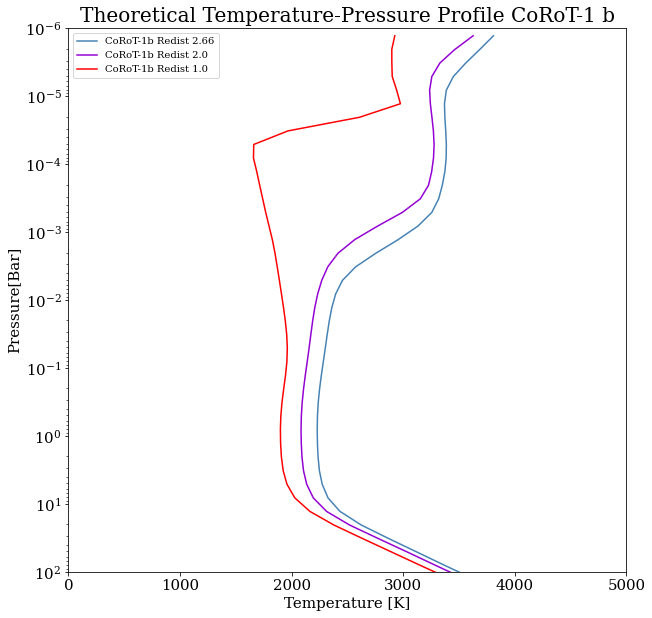

In [21]:
# Plot The T-P Profile CHIMERA models corresponding to the secondary eclipse spectra models. 

fig,ax=plt.subplots(figsize=(10,10)) #set up the figure space

ax.plot(TP_redist_266['T[K]'],TP_redist_266['P[bar]'],color='steelblue', label='CoRoT-1b Redist 2.66') #No Heat Redistribution Secondary Eclipse Model for CoRoT-1 b
ax.plot(TP_redist_2['T[K]'],TP_redist_2['P[bar]'], color='darkviolet', label='CoRoT-1b Redist 2.0') #Dayside Only Heat Redistribution Secondary Eclipse Model for CoRoT-1 b
ax.plot(TP_redist_1['T[K]'],TP_redist_1['P[bar]'], color='red', label='CoRoT-1b Redist 1.0') #Full Heat Redistribution Secondary Eclipse Model for CoRoT-1 b

#Plot labels/limits
ax.set_ylim(10**2, 10**-6)
ax.set_xlim(0,5000)
ax.set_yscale('log')

ax.legend()
ax.set_title("Theoretical Temperature-Pressure Profile CoRoT-1 b", fontsize=20)
ax.set_ylabel("Pressure[Bar]", fontsize=15)
ax.set_xlabel("Temperature [K]", fontsize=15)
ax.tick_params(axis = 'both',labelsize = 15)


#fig.savefig('saved_figures/CoRoT-1b_MCMC_Theoretical_TP_Profile.jpeg')